# Data Engineering Capstone Project Corruption
### Data Engineering Capstone Project

#### Project Summary
The goal of this project was to create ETL pipleine for immigration, temperature data, state and world corruption perceptions index data. We could try to find answears to questions such as, do people from countries with low or high CPI index immigrate to the US in large numbers, or do people from countries with warmer or cold climate immigrate to the US in large numbers?

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

### Import libaries

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import configparser
import datetime as dt

from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import sum as _sum
from pyspark.sql.window import Window
import requests
requests.packages.urllib3.disable_warnings()

import etl_function

### Load Configuration Data and Spark Session

In [ ]:
import os
import configparser
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = "/opt/conda/bin:/opt/spark-2.4.3-bin-hadoop2.7/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/lib/jvm/java-8-openjdk-amd64/bin"
os.environ["SPARK_HOME"] = "/opt/spark-2.4.3-bin-hadoop2.7"
os.environ["HADOOP_HOME"] = "/opt/spark-2.4.3-bin-hadoop2.7"

config = configparser.ConfigParser()
config.read('iam.cfg')
os.environ['AWS_ACCESS_KEY_ID']=config['AWS_CREDS']['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY']=config['AWS_CREDS']['AWS_SECRET_ACCESS_KEY']

In [ ]:
### Create a SparkSession
spark = SparkSession.builder\
    .config("spark.jars.repositories", "https://repos.spark-packages.org/")\
    .config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11").\
    enableHiveSupport().getOrCreate()

### Step 1: Scope the Project and Gather Data
________
To create the database through the following steps:
- Use Spark to load the data into dataframes.
- Data analysis and data cleaning of I94 immigration dataset, temperature dataset, state and world CPI(Corruption Perceptions Index) data.
- Create immigration calendar dimension table from I94 immigration dataset and this table links to the fact table through the arrdate field.
- Create country dimension table from the I94 immigration dataset.
- Create country dimension table from the I94 immigration and the global temperatures dataset. The global land temperatures data was aggregated at country level. The table links to the fact table through the country of residence code allowing analysts to understand correlation between country of residence climate and immigration to US states.
- Create corruption dimension table from the CPI data and this table links to the fact table through the state code field.
- Create visa dimension table from the I94 immigration data and this table links to the fact table through the visa_type_key field.
- Create fact table from the clean I94 immigration dataset and the visa_type dimension.

### Data Load and Descriptions
______
#### I94 Immigration Data: Data Description
________
This data comes from the US National Tourism and Trade Office. In the past all foreign visitors to the U.S. arriving via air or sea were required to complete paper Customs and Border Protection Form I-94 Arrival/Departure Record or Form I-94W Nonimmigrant Visa Waiver Arrival/Departure Record and this dataset comes from this forms.  

This dataset forms the core of the data warehouse and the customer repository has a years worth of data for the year 2016 and the dataset is divided by month. For this project the data is in a folder located at ../../data/18-83510-I94-Data-2016/. Each months data is stored in an SAS binary database storage format sas7bdat. For this project we have chosen going to work with data for the month of April. However, the data extraction, transformation and loading utility functions have been designed to work with any month's worth of data.

#### Take a look at Immigration dataset

In [ ]:
# Read in the data here
fname = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
immigration_df =spark.read.format('com.github.saurfang.sas.spark').load(fname)

In [ ]:
immigration_df.limit(5).toPandas()

In [ ]:
print('{:,}'.format(immigration_df.count()))

#### Data dictionary - I94 Immigration dataset


| **Feature** | **Description**                                                                    |
|-------------|------------------------------------------------------------------------------------|
| cicid       | Unique record ID                                                                   |
| i94yr       | 4 digit year                                                                       |
| i94mon      | Numeric month                                                                      |
| i94cit      | 3 digit code for immigrant country of birth                                        |
| i94res      | 3 digit code for immigrant country of residence                                    |
| i94port     | Port of admission                                                                  |
| arrdate     | Arrival Date in the USA                                                            |
| i94mode     | Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported)              |
| i94addr     | USA State of arrival                                                               |
| depdate     | Departure Date from the USA                                                        |
| i94bir      | Age of Respondent in Years                                                         |
| i94visa     | Visa codes collapsed into three categories                                         |
| count       | Field used for summary statistics                                                  |
| dtadfile    | Character Date Field - Date added to I-94 Files                                    |
| visapost    | Department of State where where Visa was issued                                    |
| occup       | Occupation that will be performed in U.S                                           |
| entdepa     | Arrival Flag - admitted or paroled into the U.S.                                   |
| entdepd     | Departure Flag - Departed, lost I-94 or is deceased                                |
| entdepu     | Update Flag - Either apprehended, overstayed, adjusted to perm residence           |
| matflag     | Match flag - Match of arrival and departure records                                |
| biryear     | 4 digit year of birth                                                              |
| dtaddto     | Character Date Field - Date to which admitted to U.S. (allowed to stay until)      |
| gender      | Non-immigrant sex                                                                  |
| insnum      | INS number                                                                         |
| airline     | Airline used to arrive in U.S.                                                     |
| admnum      | Admission Number                                                                   |
| fltno       | Flight number of Airline used to arrive in U.S.                                    |
| visatype    | Class of admission legally admitting the non-immigrant to temporarily stay in U.S. |

### World Temperature Data
____________  
The World Temperature dataset comes from Kaggle and represents global land temperatures by city.

In [ ]:
file_name = '../../data2/GlobalLandTemperaturesByCity.csv'
temperature_df = spark.read.csv(file_name, header=True, inferSchema=True)

In [ ]:
temperature_df.show(n=5, truncate=False)

In [ ]:
print('{:,}'.format(temperature_df.count()))

### Data dictionary


|            Feature            |                 Description                |
|-------------------------------|--------------------------------------------|
| dt                            | Date                                       |
| AverageTemperature            | Global average land temperature in celsius |
| AverageTemperatureUncertainty | 95% confidence interval around the average |
| City                          | Name of City                               |
| Country                       | Name of Country                            |
| Latitude                      | City Latitude                              |
| Longitude                     | City Longitude                             |

### U.S. City Demographic Data

In [ ]:
file_name = "us-cities-demographics.csv"
demographics_df = spark.read.csv(file_name, inferSchema=True, header=True, sep=';')
demographics_df.limit(5).toPandas()

#### Data dictionary
|         Feature        |                          Description                          |
|------------------------|---------------------------------------------------------------|
| City                   | City Name                                                     |
| State                  | US State where city is located                                |
| Median Age             | Median age of the population                                  |
| Male Population        | Count of male population                                      |
| Female Population      | Count of female population                                    |
| Total Population       | Count of total population                                     |
| Number of Veterans     | Count of total Veterans                                       |
| Foreign born           | Count of residents of the city that were not born in the city |
| Average Household Size | Average city household size                                   |
| State Code             | Code of the US state                                          |
| Race                   | Respondent race                                               |
| Count                  | Count of city's individual per race                                                               |

In [ ]:
print('{:,}'.format(demographics_df.count()))

#### Observations
- The World Temperature are the bigger dataframe follow by the Immigration and at last the U.S. City Demographic.

In [ ]:
temperature_df.printSchema()

In [ ]:
# create a nan dataframe 
temperature_df = temperature_df.withColumn('dt', col('dt').cast(StringType()))
nan_df = temperature_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in temperature_df.columns]).toPandas()

# display nan sum
nan_df.sum()

#### Data cleaning steps:
- Drop rows with missing average temperature
- Drop duplicate rows with columns `id`,`city`,`country`

In [ ]:
total_records = temperature_df.count()

print(f'Total records in dataframe: {total_records:,}')

# drop rows with missing average temperature
temperature_drop_df = temperature_df.dropna(subset=['AverageTemperature'])

total_recs_after_dropping_nas = temperature_drop_df.count()
print('Total records after dropping rows with missing values: {:,}'.format(total_records-total_recs_after_dropping_nas))

# drop duplicate rows
new_temperature_df = temperature_drop_df.drop_duplicates(subset=['dt', 'City', 'Country'])
print('Rows dropped after accounting for duplicates: {:,}'.format(total_recs_after_dropping_nas-new_temperature_df.count()))

### EDA: U.S. City Demographic Data

In [ ]:
demographics_df.printSchema()

In [ ]:
# view missing values
nulls_df = pd.DataFrame(data= demographics_df.toPandas().isnull().sum(), columns=['values']) # filtering only the null values
nulls_df = nulls_df.reset_index()  # set index for the row
nulls_df.columns = ['cols', 'values']  # set columns
nulls_df['% missing values'] = 100*nulls_df['values']/demographics_df.count() # calculate % missing values
nulls_df[nulls_df['% missing values'] > 0] #show only records with missing values are bigger then 0

#### Data Cleaning Steps
- This dataset has very few missing values and it is thus safe to drop records with missing values
- Drop duplicate columns

In [ ]:
subset_cols = [
    'Male Population',
    'Female Population',
    'Number of Veterans',
    'Foreign-born',
    'Average Household Size'
]
new_df = demographics_df.dropna(subset=subset_cols)

rows_dropped = demographics_df.count()-new_df.count()
print("Rows dropped with missing values: {}".format(rows_dropped))

# drop duplicate columns
new_demographics_df = new_df.dropDuplicates(subset=['City', 'State', 'State Code', 'Race'])

rows_dropped_with_duplicates = new_df.count()-new_demographics_df.count()
print(f"Rows dropped after accounting for duplicates: {rows_dropped_with_duplicates}")

In [ ]:
new_demographics_df.count()

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model

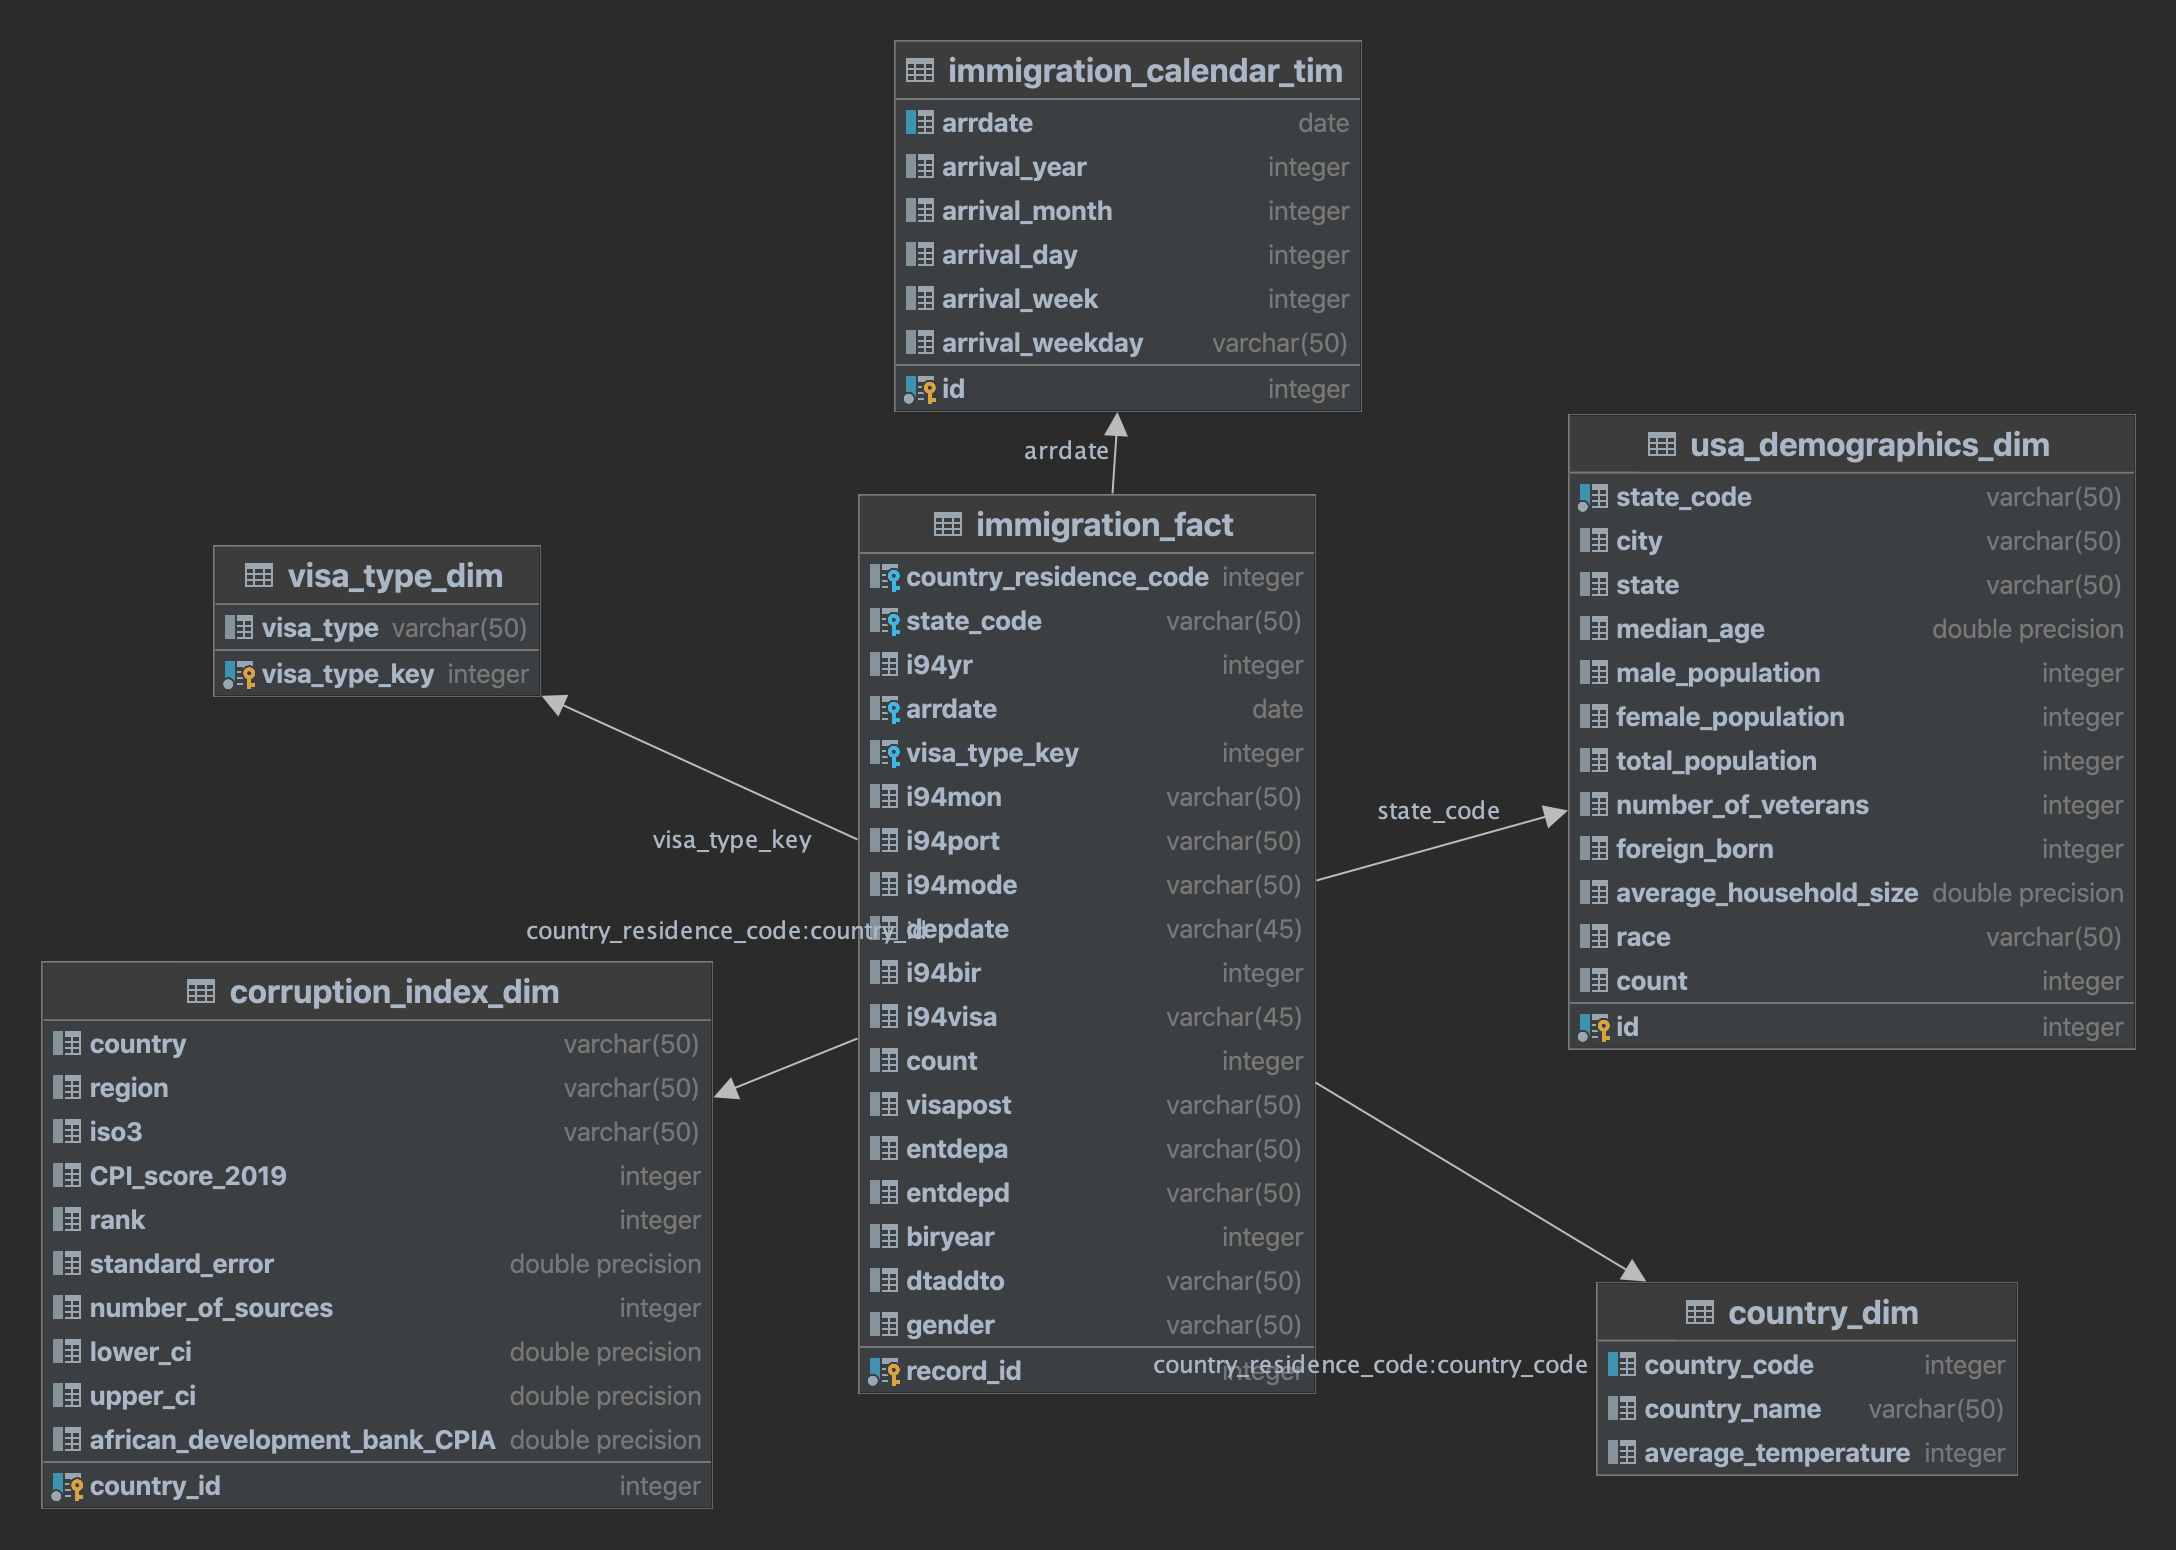

In [1]:
from IPython.display import Image
Image(filename='image/data_model_diagram.png') 

The country dimension table is made up of data from the global land temperatures by city and the immigration datasets. The combination of these two datasets allows analysts to study correlations between global land temperatures and immigration patterns to the US.

The us demographics dimension table comes from the demographics dataset and links to the immigration fact table at US state level. This dimension would allow analysts to get insights into migration patterns into the US based on demographics as well as overall population of states. We could ask questions such as, do populous states attract more visitors on a monthly basis? One envisions a dashboard that could be designed based on the data model with drill downs into gradular information on visits to the US. Such a dashboard could foster a culture of data driven decision making within tourism and immigration departments at state level.

The visa type dimension table comes from the immigration datasets and links to the immigaration via the visa_type_key.

The immigration fact table is the heart of the data model. This table's data comes from the immigration data sets and contains keys that links to the dimension tables. The data dictionary of the immigration dataset contains detailed information on the data that makes up the fact table.

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

- Load the datasets
- Clean the I94 Immigration data to create Spark dataframe for each month
- Create visa_type dimension table
- Create calendar dimension table
- Extract clean global temperatures data
- Create country dimension table
- Create immigration fact table
- Load demographics data
- Clean demographics data
- Create demographic dimension table

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

#### Create immigration dimension table
----------

In [ ]:
output_data = "output_tables/"

In [ ]:
calendar_df = etl_function.create_immigration_calendar_dimension(new_immigration_df, output_data)

#### Create Country dimension table
----------

In [ ]:
country_dim_f = etl_function.create_country_dimension_table(new_immigration_df, new_temperature_df, output_data)

In [ ]:
country_dim_f.show(5)

#### Create visa type dimension table
----------

In [ ]:
# test create visa_type dimension function
dim_visatype_df = etl_function.create_visa_type_dimension_table(new_immigration_df, output_data)

In [ ]:
dim_visatype_df.show(n=5)

#### Create demographics dimension table
----------

In [ ]:
demographics_dim_df = etl_function.create_demogra_dim_table(new_demographics_df, output_data)

In [ ]:
demographics_dim_df.limit(5).toPandas()

#### Create corruption index dimension table
----------

In [ ]:
new_cpi_df = etl_function.create_corruption_dim_table(cpi_df, output_data)

In [ ]:
new_cpi_df.limit(5).toPandas()

#### Create immigration dimension table
----------

In [ ]:
immigration_fact_df = etl_function.create_immi_fact_table(spark, new_immigration_df, output_data)

#### 4.2 Data Quality Checks
Data count checks on fact and dimension table to be ensure that ETL procedure works fine.

 
Run Quality Checks

In [ ]:
table_mapping = {
    'immigration_fact': 'record_id',
    'demographics': 'id',
    'visatype': 'visa_type_key',
    'country': 'country_code',
    'immigration_calendar': 'arrival_day',
    'corruption': 'country_id'
}

In [ ]:
# Perform quality checks here    
import etl_function

for table_name, table_id in table_mapping.items():
    # quality check for table
    etl_function.quality_checks(spark, table_name, table_id,output_data)

#### 4.3 Query Example to check ETL has processed the result in the final data model

Let's see if immigrants would generally flock to cities with generally more immigrants

In [ ]:
# group demographics dim by state_code to get total foreign_born count for each state and order num
w = Window().orderBy(col('foreign_born').desc())
demographics_df = spark.read.parquet(output_data + 'demographics')
demographics_topN = demographics_df.groupBy(['state_code','state']).agg(_sum("foreign_born") \
                    .alias('foreign_born')) \
                    .withColumn("row_num", row_number().over(w)) \
                    .orderBy("row_num")
demographics_topN.show(n=100)

In [ ]:
immigration_fact_df = spark.read.parquet(output_data + 'immigration_fact')
immigration_topN = immigration_fact_df.groupBy(['state_code']).count() \
.where(col('state_code').isNotNull()).orderBy(col('count').desc()) \
.withColumnRenamed('count','immigration_count')
immigration_topN.show(5)

In [ ]:
df_joined = immigration_topN.join(demographics_topN, 'state_code').orderBy(col('immigration_count').desc())
df_joined.show(10)

We can see generally top 10 cities with the most immigrants are indeed cities with the largest foreign-born counts except Hawaii.

In [51]:
df_joined = immigration_topN.join(demographics_topN, 'state_code').orderBy(col('immigration_count').desc())
df_joined.show(10)

+----------+-----------------+-------------+------------+-------+
|state_code|immigration_count|        state|foreign_born|row_num|
+----------+-----------------+-------------+------------+-------+
|        FL|           621701|      Florida|     7833464|      4|
|        NY|           553677|     New York|    17186873|      2|
|        CA|           470386|   California|    37059662|      1|
|        HI|           168764|       Hawaii|      506560|     28|
|        TX|           134321|        Texas|    14498054|      3|
|        NV|           114609|       Nevada|     2406685|      8|
|        IL|            82126|     Illinois|     4632600|      5|
|        NJ|            76531|   New Jersey|     2327750|      9|
|        MA|            70486|Massachusetts|     2573815|      7|
|        WA|            55792|   Washington|     2204810|     10|
+----------+-----------------+-------------+------------+-------+
only showing top 10 rows



We can see generally top 10 cities with the most immigrants are indeed cities with the largest foreign-born counts except Hawaii.

#### 4.3 Data dictionary 
##### Fact Table - data dictionary

|    Feature    	|                                  Description                                  	|
|---------------	|-------------------------------------------------------------------------------	|
| id            	| Unique record ID                                                              	|
| country_residence_code  	| 3 digit code for immigrant country of residence                               	|
| visa_type_key 	| A numerical key that links to the visa_type dimension table                   	|
| state_code    	| US state of arrival                                                           	|
| i94cit        	| country code for immigrant country of birth                                   	|
| i94yr         	| 4 digit year                                                                  	|
| i94mon        	| Numeric month                                                                 	|
| i94port       	| Port of admission                                                             	|
| arrdate       	| Arrival Date in the USA                                                       	|
| i94mode       	| Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported)         	|
| depdate       	| Departure Date from the USA                                                   	|
| i94bir        	| Age of Respondent in Years                                                    	|
| i94visa       	| Visa codes collapsed into three categories                                    	|
| count         	| Field used for summary statistics                                             	|
| dtadfile      	| Character Date Field - Date added to I-94 Files                               	|
| visapost      	| Department of State where where Visa was issued                               	|
| entdepa       	| Arrival Flag - admitted or paroled into the U.S.                              	|
| entdepd       	| Departure Flag - Departed, lost I-94 or is deceased                           	|
| matflag       	| Match flag - Match of arrival and departure records                           	|
| biryear       	| 4 digit year of birth                                                         	|
| dtaddto       	| Character Date Field - Date to which admitted to U.S. (allowed to stay until) 	|
| gender        	| Non-immigrant sex                                                             	|
| airline       	| Airline used to arrive in U.S.                                                	|
| admnum        	| Admission Number                                                              	|
| fltno         	| Flight number of Airline used to arrive in U.S.                               	|

##### Country Dimension Table - data dictionary
The country code and country_name fields

|    Feature   	|     Description     	|
|--------------	|---------------------	|
| country_code 	| Unique country code 	|
| country_name 	| Name of country     	|
| average_temperature 	|Average temperature of country     	|

##### Visa Type Dimension Table - data dictionary
|  Feature  	|           Description          	|
|-----------	|--------------------------------	|
| visa_key  	| Unique id for each visa issued 	|
| visa_type 	| Name of visa                   	|

##### Immigration Calendar Dimension Table - data dictionary
The whole of this dataset comes from the immigration dataset.

| Feature              	| Description            	|
|-----------------	|----------------------	|
| id              	| Unique id            	|
| arrdate         	| Arrival date into US 	|
| arrival_year    	| Arrival year into US 	|
| arrival_month   	| Arrival MonthS       	|
| arrival_day     	| Arrival Day          	|
| arrival_week    	| Arrival Week         	|
| arrival_weekday 	| Arrival WeekDay      	|

##### US Demographics Dimension Table - data dictionary
The whole of this dataset comes from the us cities demographics data.

|         Feature        	|                          Description                          	|
|------------------------	|---------------------------------------------------------------	|
| id                     	| Record id                                                     	|
| state_code             	| US state code                                                 	|
| city                   	| City Name                                                     	|
| State                  	| US State where city is located                                	|
| median_age             	| Median age of the population                                  	|
| male_ population        	| Count of male population                                      	|
| female_population      	| Count of female population                                    	|
| total_population       	| Count of total population                                     	|
| number_of_veterans     	| Count of total Veterans                                       	|
| foreign_born           	| Count of residents of the city that were not born in the city 	|
| average_household_size 	| Average city household size                                   	|
| race                   	| Respondent race                                               	|
| count                  	| Count of city's individual per race                           	|

#### World Corruption Perceptions Index Dimention Table
The whole of this dataset comes from  Corruption Perceptions Report 2019.

|            Feature            	|                                           Description                                          	|
|-------------------------------	|------------------------------------------------------------------------------------------------	|
| country_id                    	| Country id                                                                                     	|
| country                       	| Name of country                                                                                	|
| region                        	| The region the country belongs to                                                              	|
| ISO3                          	| ISO code for the country                                                                       	|
| CPI_score_2019                	| The 2019 CPI score as a percentage from 0 to 100                                               	|
| rank                          	| The rank of the country in terms of anti-corruption                                            	|
| standard_error                	| the standard deviation of its sampling distribution or an estimate of that standard deviation. 	|
| number_of_sources             	| How many sources were used                                                                     	|
| lower_ci                      	| lower confidence interval                                                                      	|
| upper_ci                      	| upper confidence interval                                                                      	|
| african_development_bank_CPIA 	| African Development Bank Governance Ratings                                                    	|

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
    - I use Apache Spark beacause it's ability to handle multiple file formats with large amounts of data and it's fast for big data and large dataset. Immigration data will be updated mounthly and other data yearly.
* Propose how often the data should be updated and why.
    - The current I94 immigration data is updated monthly, and hence the data will be updated monthly.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
     - Spark can handle the increase but we would consider increasing the number of nodes in our cluster.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
     - In this scenario, Apache Airflow will be used to schedule and run data pipelines.
 * The database needed to be accessed by 100+ people.
     -  We can use Amazon Redshift.